In [1]:
from matplotlib.patches import Rectangle
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import seaborn as sns

In [2]:
CORONA_PATH = "/m/cs/work/luongn1/digirhythm/data/processed/corona/similarity_matrix/"

study = "corona"
uid = "3539009742"
freq = "4epochs"

# Take a sample
behavior_vector = pd.read_csv(
    f"/m/cs/work/luongn1/digirhythm/data/processed/corona/vector_corona_{freq}.csv"
)
sample = pd.read_csv(CORONA_PATH + f"{freq}/similarity_{uid}.csv", index_col=0)
similarity_baseline_si = pd.read_csv(
    CORONA_PATH + f"si/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_cluster = pd.read_csv(
    CORONA_PATH + f"cluster/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_average = pd.read_csv(
    CORONA_PATH + f"average/similarity_baseline_{freq}.csv", index_col=0
)
similarity_baseline_si.index = similarity_baseline_si.index.astype("str")
similarity_baseline_cluster.index = similarity_baseline_cluster.index.astype("str")
similarity_baseline_average.index = similarity_baseline_cluster.index.astype("str")
behavior_vector.subject_id = behavior_vector.subject_id.astype("str")

with open("../config/features.txt") as f:
    features_dict = json.load(f)
    FEATURES = features_dict[study][freq]


<div class="alert alert-block alert-info">
<h1> Visualization of baseline computation </h1>
Step by step guid of how baseline is computed
</div>

# Stability index

Kernel size: 7. Stable region 5 - 12


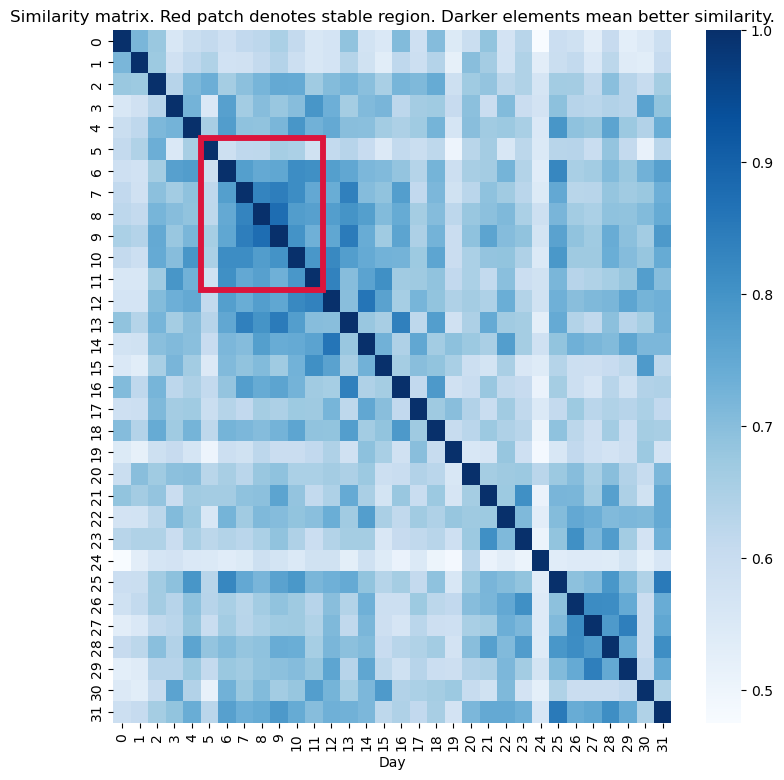

In [3]:
def euclidean_similarity(values):
    d = euclidean_distances(values)
    return 1 / (1 + d)  # np.exp(-d)


def similarity_matrix(sample, uid):
    """
    Return dictionary of similarity matrix
    """

    # Reindex the DataFrame to include all dates in the range, filling missing ones
    #    date_range = pd.date_range(start=sample.index.min(), end=sample.index.max(), freq='D')
    #    sample = sample.reindex(date_range)

    # Compute the cosine similarity
    similarity = euclidean_similarity(sample.values)

    # Convert to DataFrame
    similarity_df = pd.DataFrame(similarity)

    return similarity_df


def stability_score(similarity_matrix, kernel_size=7):
    size = similarity_matrix.shape[0] - kernel_size - 1

    # Extract the similarity values of consecutive elements
    consecutive_similarity = np.diag(
        similarity_matrix, k=1
    )  # k=1 for one above the main diagonal

    stability_scores = []
    for i in range(0, size):
        kernel = consecutive_similarity[i : i + kernel_size]
        stability_scores.append(np.median(kernel))
    # Slide
    return stability_scores


def largest_stability_score(stability_score):
    if len(stability_score) == 0:
        return np.nan
    return np.array(stability_score).argmax()


def calculate_baseline_si(df, si_max, kernel_size):
    """
    Get the region with highest SI, then average
    """

    region = df.iloc[si_max : si_max + kernel_size]
    baseline = region.mean(axis=0)

    return baseline


kernel_size = 7 if freq == "4epochs" else 4

sample_behaviour = behavior_vector[behavior_vector.subject_id == uid][FEATURES]
sample_behaviour.dropna(inplace=True, subset=FEATURES)
sample_behaviour = sample_behaviour[0::7]

# print(sample.shape)
sm = similarity_matrix(sample_behaviour, uid)
si_score = stability_score(sm, kernel_size)
si_max = largest_stability_score(si_score)

# Heatmap
plt.figure(figsize=(9, 9))
ax = sns.heatmap(sm, cmap="Blues")
xlabel = "Day" if freq == "4epochs" else "Week"

x, y, w, h = si_max, si_max, kernel_size, kernel_size
for _ in range(2):
    ax.add_patch(
        Rectangle((x, y), w, h, fill=False, edgecolor="crimson", lw=4, clip_on=False)
    )
    x, y = y, x  # exchange the roles of x and y
    w, h = h, w  # exchange the roles of w and h

plt.xlabel(xlabel)
plt.title(
    "Similarity matrix. Red patch denotes stable region. Darker elements mean better similarity."
)

print(f"Kernel size: {kernel_size}. Stable region {si_max} - {si_max + kernel_size}")

# Clustering

In [4]:
FEATURES = [
    "heart_rate_variability_avg:norm",
    "stepsx1000:total:norm",
    "steps:night:norm",
    "steps:morning:norm",
    "steps:afternoon:norm",
    "steps:evening:norm",
    "tst:norm",
    "midsleep:norm",
]
CORONA_PATH = (
    "/m/cs/work/luongn1/digirhythm/data/processed/corona/vector_corona_4epochs.csv"
)


freq = "7ds"

# Take a sample
data = pd.read_csv(CORONA_PATH, index_col=0)
data.subject_id = data.subject_id.astype("str")
s = data[data.subject_id == uid]

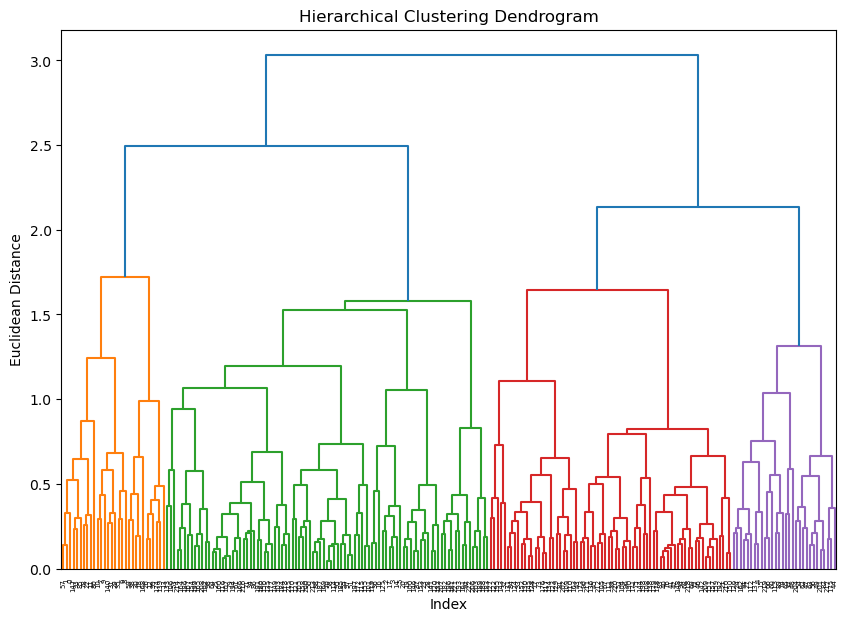

In [5]:
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler

# Perform hierarchical clustering
linked = linkage(s[FEATURES], "ward")

# Plot the dendrogram
plt.figure(figsize=(10, 7))
dendrogram(linked, orientation="top", distance_sort="descending", show_leaf_counts=True)
plt.title("Hierarchical Clustering Dendrogram")
plt.xlabel("Index")
plt.ylabel("Euclidean Distance")
plt.show()